# Intro
This notebook is developed to predict the stock market closing price
for a certain company, e.g. Apple Inc., based on Yahoo Finance data, and using a recurrent neural network 
(RNN) variation called Long Short Term Memory (LSTM).

Inspiration source - code developed following: https://www.youtube.com/watch?v=QIUxPv5PJOY

# Install and import libraries

In [2]:
#pip install yfinance
# Had to install this version of numpy for compatibility purposes
# pip install "numpy>=1.16.5,<1.23.0"

In [2]:
# Import the libraries
import math
import pandas as pd
import pandas_datareader as web
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
plt.style.use('fivethirtyeight')
import yfinance as yf

# Data import

In [10]:
# Get the data
df = yf.download("AAPL", start="2013-01-01", end="2023-01-01")

df.info()
df.tail()

[*********************100%***********************]  1 of 1 completed
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2518 entries, 2013-01-02 to 2022-12-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2518 non-null   float64
 1   High       2518 non-null   float64
 2   Low        2518 non-null   float64
 3   Close      2518 non-null   float64
 4   Adj Close  2518 non-null   float64
 5   Volume     2518 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 137.7 KB


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-12-23,130.919998,132.419998,129.639999,131.860001,131.860001,63814900
2022-12-27,131.380005,131.410004,128.720001,130.029999,130.029999,69007800
2022-12-28,129.669998,131.029999,125.870003,126.040001,126.040001,85438400
2022-12-29,127.989998,130.479996,127.730003,129.610001,129.610001,75703700
2022-12-30,128.410004,129.949997,127.430000,129.929993,129.929993,76960600


In [11]:
# Get the data set dimension
df.shape

(2768, 6)

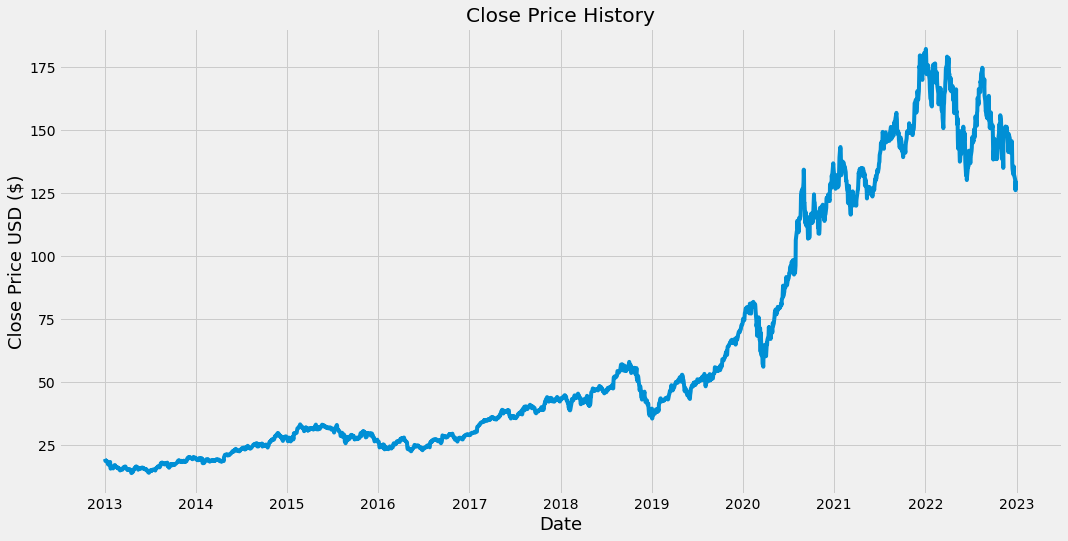

In [12]:
# Plot the stock closing price over time
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()



# Training 

In [20]:
# Keep only the 'Close' column of the dataframe
dataset = df[['Close']]

# Convert the dataframe to a numpy array
# dataset = data.values

# Get X% of rows (e.g. 80%) to train the model on
training_data_len = math.ceil(len(dataset) * 0.8)
print("training_data_len:", training_data_len)

dataset

training_data_len: 2015


,Close
Date,
2013-01-02,19.608213
2013-01-03,19.360714
2013-01-04,18.821428
2013-01-07,18.710714
2013-01-08,18.761070
...,...
2022-12-23,131.860001
2022-12-27,130.029999
2022-12-28,126.040001


In [21]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.03368219],
       [0.03220953],
       [0.02900069],
       ...,
       [0.66696916],
       [0.68821126],
       [0.69011526]])

In [27]:
# Create the training data set
# Create the scaled training data set
train_data = scaled_data[0:training_data_len, :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []
# lookback window (time-steps)
window = 60

for i in range(window, len(train_data)):
    x_train.append(train_data[i-window:i, 0])
    y_train.append(train_data[i, 0])
    if i<=window: # change it to window +1 to print the next iteration
        print(x_train)
        print(y_train)
        print()

[array([0.03368219, 0.03220953, 0.02900069, 0.02834192, 0.02864155,
       0.02689688, 0.02825905, 0.02757691, 0.02363492, 0.02027095,
       0.02455719, 0.02383254, 0.02326303, 0.02427668, 0.02624024,
       0.01274399, 0.01048717, 0.0126016 , 0.01439515, 0.01408915,
       0.01380439, 0.013407  , 0.01100568, 0.01430378, 0.01419965,
       0.01650959, 0.01794613, 0.01899803, 0.01644159, 0.01625246,
       0.01616321, 0.01479679, 0.01476066, 0.01239335, 0.01180045,
       0.01280986, 0.01110769, 0.01241885, 0.01148382, 0.01081018,
       0.00848749, 0.00627318, 0.00862986, 0.00746533, 0.00851086,
       0.00875312, 0.01006003, 0.00805397, 0.00803697, 0.00891888,
       0.01129044, 0.01385327, 0.01359189, 0.01307974, 0.01321787,
       0.01516868, 0.01552356, 0.01500505, 0.01307974, 0.01107794])]
[0.008155979080942843]



In [28]:
# Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [29]:
# Reshape the data to be compatibe for LSTM requiring data to be 3-dim in the form of number of samples, time steps and features 
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)) # '1' at the end is the number of features
x_train.shape

(1955, 60, 1)

In [30]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1))) # '1' at the end is the number of features
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [31]:
# Compile the model
model.compile(optimizer='adam', loss='mse')

In [32]:
# Train the model -- treat batch_size & epochs as the model parameters
model.fit(x_train, y_train, batch_size=1, epochs=1)

1955/1955 [==============================] - 36s 16ms/step - loss: 8.2900e-04


In [35]:
# Create the testing data set
# Create a new array containing scaled values from index (training set length) to index (end of dataset)
test_data = scaled_data[training_data_len - window: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset.values[training_data_len: , :]
for i in range(window, len(test_data)):
    x_test.append(test_data[i-window:i, 0])

In [36]:
# Convert the data into a numpy array
x_test = np.array(x_test)

In [39]:
# Reshape the data from 2D to 3D for LSTM compatiblity 
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1)) # '1' at the end is the number of features

In [40]:
# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

16/16 [==============================] - 4s 9ms/step


In [41]:
# Evaluation - one example measure: Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean((predictions - y_test)**2))
#rmse2 = sklearn.metrics.mean_squared_error(predictions, y_test)
rmse

5.310678909796464

# Performance visualization

<ipython-input-53-331c66c93cf6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictations'] = predictions


<Figure size 2304x1152 with 0 Axes>

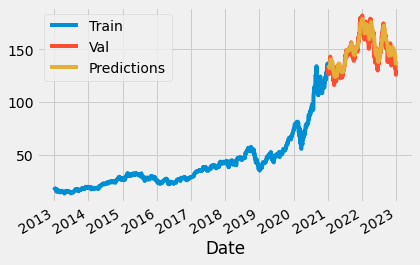

In [53]:
# Plot the data
train = dataset[:training_data_len]
valid = dataset[training_data_len:]
valid['Predictations'] = predictions

# # Visualize the data
# plt.figure(figsize=(16,8))
# plt.title('Model')
# plt.xlabel('Date', fontsize=18)
# plt.ylabel('Close Price USD ($)', fontsize=18)
# plt.plot(train['Close'])
# plt.plot(valid[['Close', 'Predictions']])
# plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
# plt.show()


# Visualize the data
plt.figure(figsize=(32,16))
firstPlot = train.plot() 
valid.plot(ax = firstPlot)
plt.legend(['Train', 'Val', 'Predictions'], loc='upper left')
plt.show()

In [54]:
# Show the valid (actual) and predicted prices
valid

,Close,Predictations
Date,,
2021-01-04,129.410004,135.378860
2021-01-05,131.009995,135.251617
2021-01-06,126.599998,135.071686
2021-01-07,130.919998,134.376663
2021-01-08,132.050003,134.033463
...,...,...
2022-12-23,131.860001,139.259995
2022-12-27,130.029999,138.302399
2022-12-28,126.040001,137.286331


# Test on next day (price prediction vs. actual)

In [59]:
# Create a new dataframe using the original data from data source
new_df = yf.download("AAPL", start="2013-01-01", end="2023-01-01")
new_df = new_df[['Close']]

# Get the last 'window' interval 
last_window = new_df[-window:]

# Scale the data to be values between 0 and 1
last_window_scaled = scaler.transform(last_window)

# Create an empty list
X_test = []

# Append the past 60 days
X_test.append(last_window_scaled)

# Convert the X_test data set to a numpy array
X_test = np.array(X_test)

# Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Get the predicted scaled price
pred_price = model.predict(X_test)

# Undo the scaling
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 0s 20ms/step
[[134.30367]]


In [68]:
# Get the actual price

apple_quote = yf.download("AAPL", start="2023-01-03", end="2023-01-04")

print(apple_quote['Close'])

[*********************100%***********************]  1 of 1 completed
Date
2023-01-03    125.07
Name: Close, dtype: float64
